In [1]:
from pathlib import Path

import pandas as pd
import petl as etl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
%matplotlib inline

In [2]:
ROOT = Path('../..')

SRC_FILE = ROOT / 'data/raw/lfs_by_pcon.csv'

OUT_DIR = ROOT / 'data/processed/labour-market/'
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_FILE = OUT_DIR / 'labour_market_by_pcon.csv'
PQ_FILE = OUT_DIR / 'labour_market_by_pcon.parquet'

Load the latest CSV. This is downloaded by the 'download-from-nomis-api.py' script.

In [3]:
data = etl.fromcsv(
  SRC_FILE
).convertall(
  lambda x: x.strip()
).convert(
  {
    'DATE': etl.dateparser('%Y-%m'),
    'OBS_VALUE': float
  }
).selecteq(
  'MEASURES_NAME', 'Variable'
).selectin(
  'GEOGRAPHY_TYPE', ['parliamentary constituencies 2010', 'Westminster Parliamentary Constituencies (July 2024)']
).cut(
  'DATE', 'DATE_NAME', 'GEOGRAPHY_CODE', 'GEOGRAPHY_NAME', 'VARIABLE_CODE', 'VARIABLE_NAME', 'OBS_VALUE', 'OBS_STATUS_NAME'
).rename({
  'DATE': 'date',
  'DATE_NAME': 'date_name',
  'GEOGRAPHY_CODE': 'geography_code',
  'GEOGRAPHY_NAME': 'geography_name',
  'VARIABLE_CODE': 'variable_code',
  'VARIABLE_NAME': 'variable_name',
  'OBS_VALUE': 'value',
  'OBS_STATUS_NAME': 'notes'
})

data

date,date_name,geography_code,geography_name,variable_code,variable_name,value,notes
2021-03-01,Apr 2020-Mar 2021,E14000554,Berwick-upon-Tweed,18,Economic activity rate - aged 16-64,75.2,Normal Value
2021-03-01,Apr 2020-Mar 2021,E14000569,Bishop Auckland,18,Economic activity rate - aged 16-64,75.2,Normal Value
2021-03-01,Apr 2020-Mar 2021,E14000574,Blaydon,18,Economic activity rate - aged 16-64,79.7,Normal Value
2021-03-01,Apr 2020-Mar 2021,E14000575,Blyth Valley,18,Economic activity rate - aged 16-64,73.9,Normal Value
2021-03-01,Apr 2020-Mar 2021,E14000641,City of Durham,18,Economic activity rate - aged 16-64,78.9,Normal Value


Save the file to CSV

In [4]:
data.tocsv(OUT_FILE)

Convert to pandas for further processing, and save Parquet file

In [5]:
frame = data.todataframe()
frame.date = pd.to_datetime(frame.date)
frame.to_parquet(PQ_FILE)

Check missing data

date,2021-03-01,2021-06-01,2021-09-01,2021-12-01,2022-03-01,2022-06-01,2022-09-01,2022-12-01,2023-03-01,2023-06-01,2023-09-01,2023-12-01,2024-03-01
variable_name,,,,,,,,,,,,,
% of economically inactive student,0.893401,0.901015,0.917090,0.898477,0.901015,0.899323,0.881557,0.857868,0.814721,0.780880,0.731810,0.718274,0.720812
% who are economically inactive - aged 16+,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772
% who are economically inactive - aged 16-19,0.842640,0.862098,0.862944,0.863790,0.858714,0.833333,0.819797,0.776650,0.735195,0.697124,0.640440,0.618443,0.626904
% who are economically inactive - aged 16-24,0.923012,0.928088,0.944162,0.925550,0.932318,0.922166,0.911168,0.880711,0.860406,0.824873,0.780034,0.763959,0.767343
% who are economically inactive - aged 16-64,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.983926,0.983080,0.981387
% who are economically inactive - aged 20-24,0.403553,0.425550,0.411168,0.384095,0.368020,0.346024,0.330795,0.328257,0.313029,0.272420,0.235195,0.208968,0.192047
Economic activity rate - aged 16-19,0.618443,0.629442,0.645516,0.635364,0.642132,0.652284,0.652284,0.594755,0.560914,0.521997,0.456853,0.427242,0.434010
Economic activity rate - aged 16-64,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772,0.984772
Economic activity rate - aged 20-24,0.920474,0.920474,0.911168,0.904399,0.899323,0.873942,0.860406,0.833333,0.798646,0.767343,0.713198,0.681049,0.686125


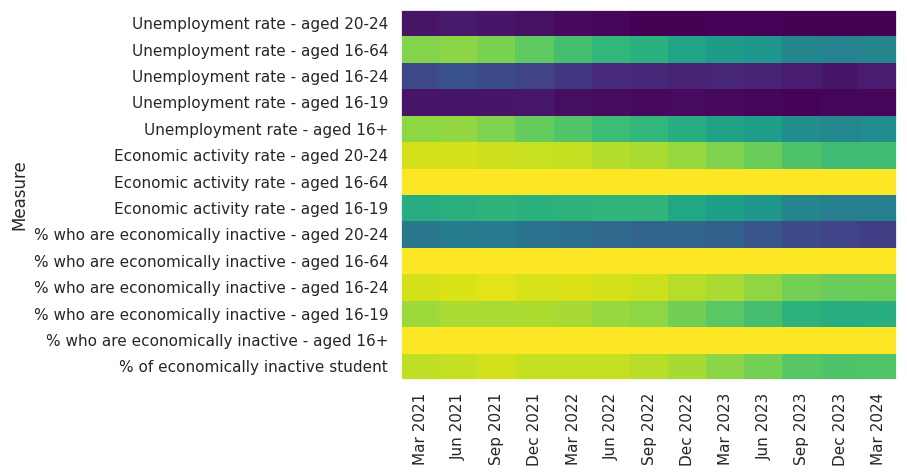

In [6]:
def visualise_coverage(data):
    counts = pd.DataFrame({
      'available': data.groupby(['date', 'variable_name']).value.count(),
      'total': data.groupby(['date', 'variable_name']).value.size()
    })
    coverage = pd.Series(
      counts.available / counts.total, name='coverage'
    ).reset_index().pivot(
      index='variable_name', columns='date', values='coverage'
    )
    plt.imshow(coverage, origin='lower', cmap='viridis', interpolation='nearest', aspect='auto')
    plt.grid(None)
    plt.ylabel('Measure')
    plt.yticks(ticks=range(len(coverage.index)), labels=coverage.index)
    plt.xticks(ticks=range(len(coverage.columns)), labels=coverage.columns.to_series().dt.strftime('%b %Y'), rotation=90, horizontalalignment='center')
    return coverage

frame.pipe(visualise_coverage)

Get the most recently published data per area, to increase coverage

In [7]:
def get_latest_available(data):
  # Calculate dates
  failsafe_date = data.date.min() - pd.Timedelta("1 days")
  latest_date = data.date.max()
  # Subset the input data
  test_data = data.loc[:, ['geography_code', 'date', 'variable_name', 'value']]
  # Construct a failsafe (to be used in the event that there is no data available)
  # This will have the same index as the most recent values, which we use below...
  failsafe_data = test_data.loc[test_data.date == latest_date]
  failsafe_data.loc[:, ['date', 'value']] = (failsafe_date, -1)
  # Concatenate the test and failsafe_data
  test_data = pd.concat([ test_data, failsafe_data ]).sort_values('date', ascending=True)
  # Get the indexes for the non-zero values
  indexes = test_data.dropna(subset='value').groupby(['geography_code', 'variable_name'])['date'].idxmax()
  return data.loc[indexes]

latest_available = frame.pipe(get_latest_available)

In [8]:
latest = frame.loc[frame.date == frame.date.max()].groupby(['variable_name']).value
patched = latest_available.groupby(['variable_name']).value
coverage = pd.DataFrame({
  'latest coverage': latest.count() / latest.size() * 100,
  'patched coverage': patched.count() / patched.size() * 100,
})

coverage

,latest coverage,patched coverage
variable_name,,
% of economically inactive student,72.081218,97.969543
% who are economically inactive - aged 16+,98.477157,98.477157
% who are economically inactive - aged 16-19,62.690355,97.715736
% who are economically inactive - aged 16-24,76.734349,98.307953
% who are economically inactive - aged 16-64,98.138748,98.477157
% who are economically inactive - aged 20-24,19.204738,71.742809
Economic activity rate - aged 16-19,43.401015,90.524535
Economic activity rate - aged 16-64,98.477157,98.477157
Economic activity rate - aged 20-24,68.612521,98.054146


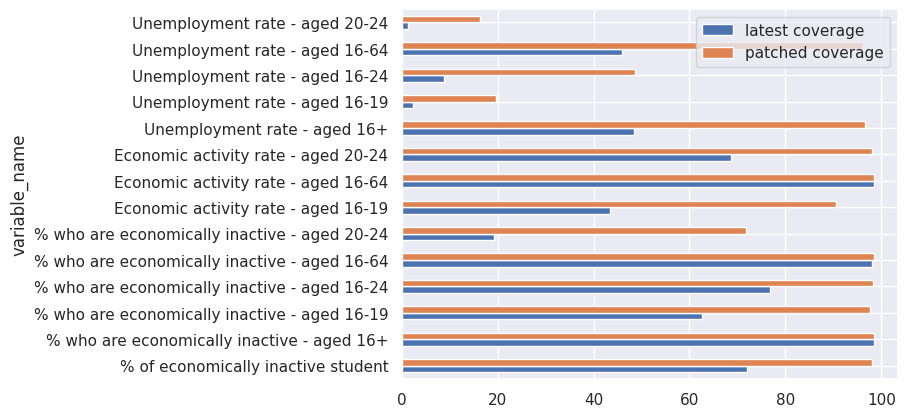

In [9]:
ax = coverage.plot.barh()